In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
#Read in a csv file with 10-minute gusts at all stations in Vic, from 2005-2015

df = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/barpac_m_aws_vic.csv").dropna(subset="gust")


In [3]:
df = df.set_index(pd.to_datetime(df["Unnamed: 1"]))

In [92]:
dmax = df[["wg10_2p2km_point","wg10_12km_point","gust","n_lightning_fl","Lightning_observed_daily","stn_id"]].groupby("stn_id").resample("1D").max()

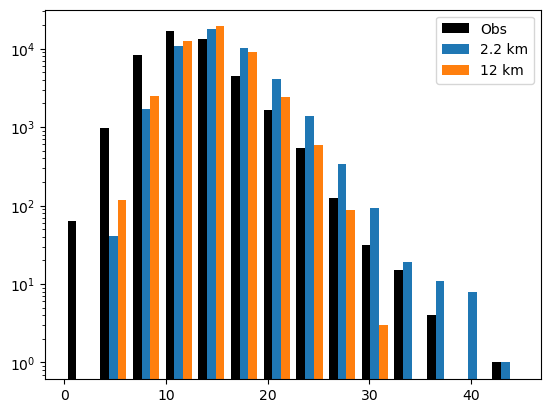

In [93]:
plt.hist(
    [dmax.query("gust<100").gust,
    dmax.wg10_2p2km_point,
    dmax.wg10_12km_point],
                        bins=np.linspace(0,45,15),log=True,label=["Obs","2.2 km","12 km"],color=["k","tab:blue","tab:orange"]);
plt.legend()

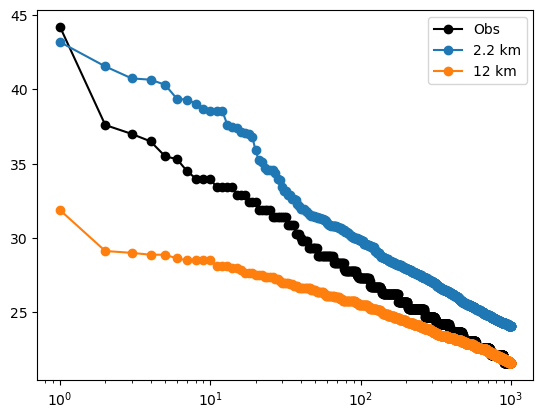

In [94]:
plt.plot(
    np.arange(1,1001),
    dmax.query("gust<100").gust.sort_values(ascending=False).iloc[0:1000],
marker="o",color="k",label="Obs")

plt.plot(
    np.arange(1,1001),
    dmax.wg10_2p2km_point.sort_values(ascending=False).iloc[0:1000],
marker="o",color="tab:blue",label="2.2 km")

plt.plot(
    np.arange(1,1001),
    dmax.wg10_12km_point.sort_values(ascending=False).iloc[0:1000],
marker="o",color="tab:orange",label="12 km")
              
plt.xscale("log")
plt.legend()

(24.0, 45.0)

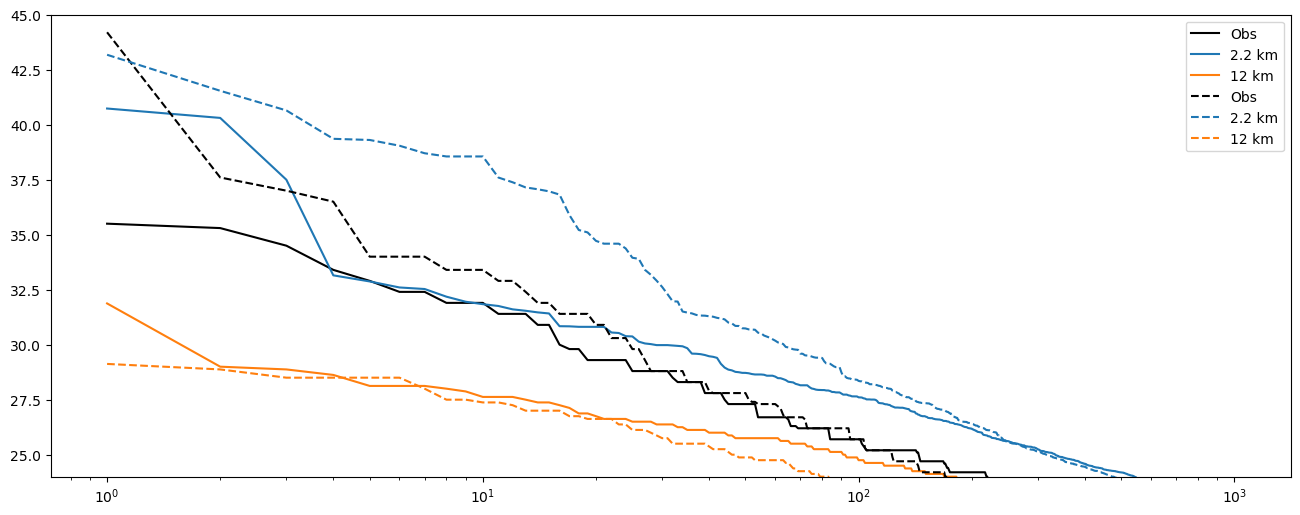

In [95]:
plt.figure(figsize=[16,6])


plt.plot(
    np.arange(1,1001),
    dmax.query("(gust<100) & (Lightning_observed_daily==0)").gust.sort_values(ascending=False).iloc[0:1000],
color="k",label="Obs")

plt.plot(
    np.arange(1,1001),
    dmax.query("n_lightning_fl==0").wg10_2p2km_point.sort_values(ascending=False).iloc[0:1000],
color="tab:blue",label="2.2 km")

plt.plot(
    np.arange(1,1001),
    dmax.query("n_lightning_fl==0").wg10_12km_point.sort_values(ascending=False).iloc[0:1000],
color="tab:orange",label="12 km")

plt.plot(
    np.arange(1,1001),
    dmax.query("(gust<100) & (Lightning_observed_daily>=1)").gust.sort_values(ascending=False).iloc[0:1000],
color="k",label="Obs",ls="--")

plt.plot(
    np.arange(1,1001),
    dmax.query("n_lightning_fl>=1").wg10_2p2km_point.sort_values(ascending=False).iloc[0:1000],
color="tab:blue",label="2.2 km",ls="--")

plt.plot(
    np.arange(1,1001),
    dmax.query("n_lightning_fl>=1").wg10_12km_point.sort_values(ascending=False).iloc[0:1000],
color="tab:orange",label="12 km",ls="--")
              
plt.xscale("log")
plt.legend()
plt.ylim([24,45])

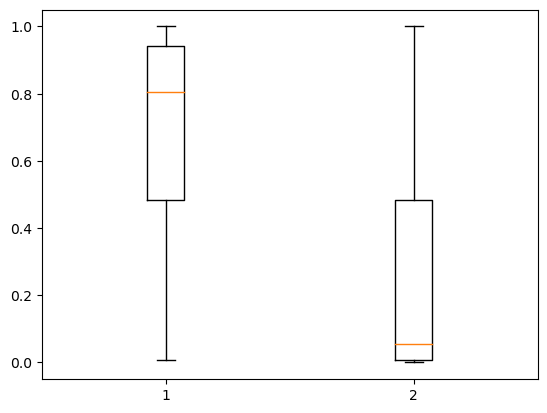

In [103]:
plt.boxplot(
    [df.query("(gust<100) & (Lightning_observed_daily>=1) & (gust>=25)").bdsd,
     df.query("(gust<25) | ((Lightning_observed_daily==1) & (gust>=25))").bdsd]);

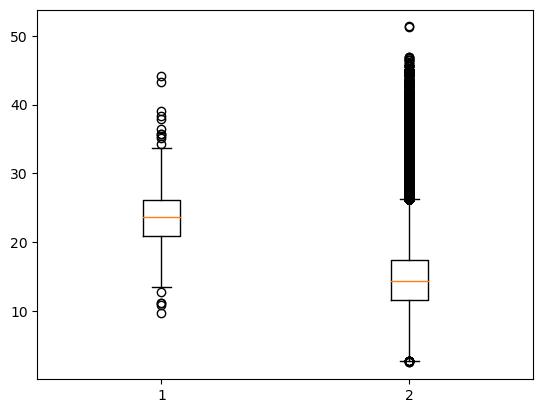

In [104]:
plt.boxplot(
    [df.query("(gust<100) & (Lightning_observed_daily>=1) & (gust>=25)").wg10_2p2km_rad,
     df.query("(gust<25) | ((Lightning_observed_daily==1) & (gust>=25))").wg10_2p2km_rad]);

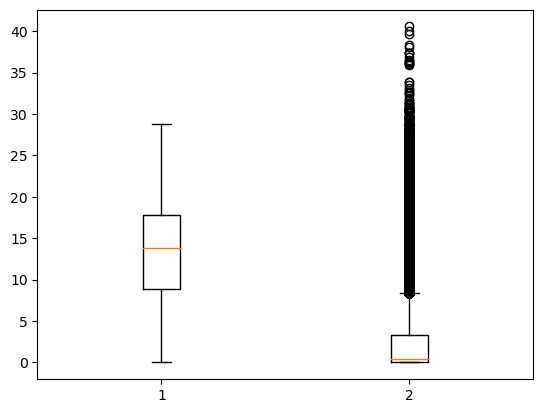

In [105]:
df["combo"] = df["wg10_2p2km_point"] * df["bdsd"]
plt.boxplot(
    [df.query("(gust<100) & (Lightning_observed_daily>=1) & (gust>=25)").combo,
     df.query("(gust<25) | ((Lightning_observed_daily==1) & (gust>=25))").combo]);

Text(0.5, 1.0, 'BARPA-R +25 m/s gusts')

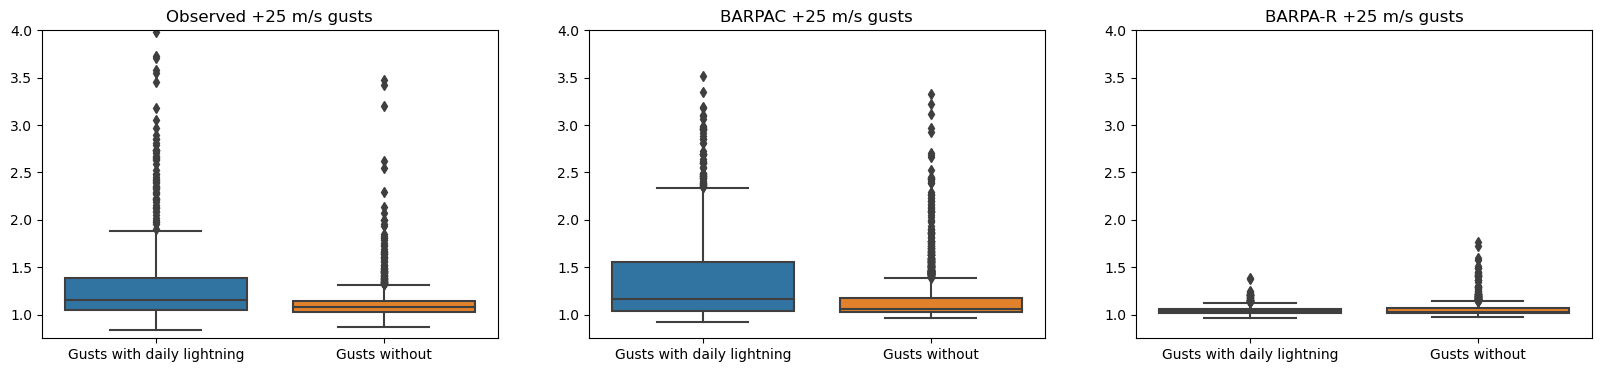

In [102]:
plt.figure(figsize=[20,4])

plt.subplot(1,3,1)

sns.boxplot(
    [df.query("(gust<100) & (Lightning_observed_daily>=1) & (gust>=25)").wgr_4,
    df.query("(gust<100) & (Lightning_observed_daily==0) & (gust>=25)").wgr_4])
plt.ylim([0.75,4])
plt.xticks([0,1],["Gusts with daily lightning","Gusts without"])
plt.title("Observed +25 m/s gusts")


plt.subplot(1,3,2)

sns.boxplot(
    [df.query("(n_lightning_fl>=1) & (wg10_2p2km_point>=25)").wgr_2p2km_point,
    df.query("(n_lightning_fl==0) & (wg10_2p2km_point>=25)").wgr_2p2km_point])
plt.ylim([0.75,4])
plt.xticks([0,1],["Gusts with daily lightning","Gusts without"])
plt.title("BARPAC +25 m/s gusts")


plt.subplot(1,3,3)

sns.boxplot(
    [df.query("(n_lightning_fl>=1) & (wg10_12km_point>=25)").wgr_12km_point,
    df.query("(n_lightning_fl==0) & (wg10_12km_point>=25)").wgr_12km_point])
plt.ylim([0.75,4])
plt.xticks([0,1],["Gusts with daily lightning","Gusts without"])
plt.title("BARPA-R +25 m/s gusts")

Text(0.5, 1.0, 'BARPA-R gusts/lightning')

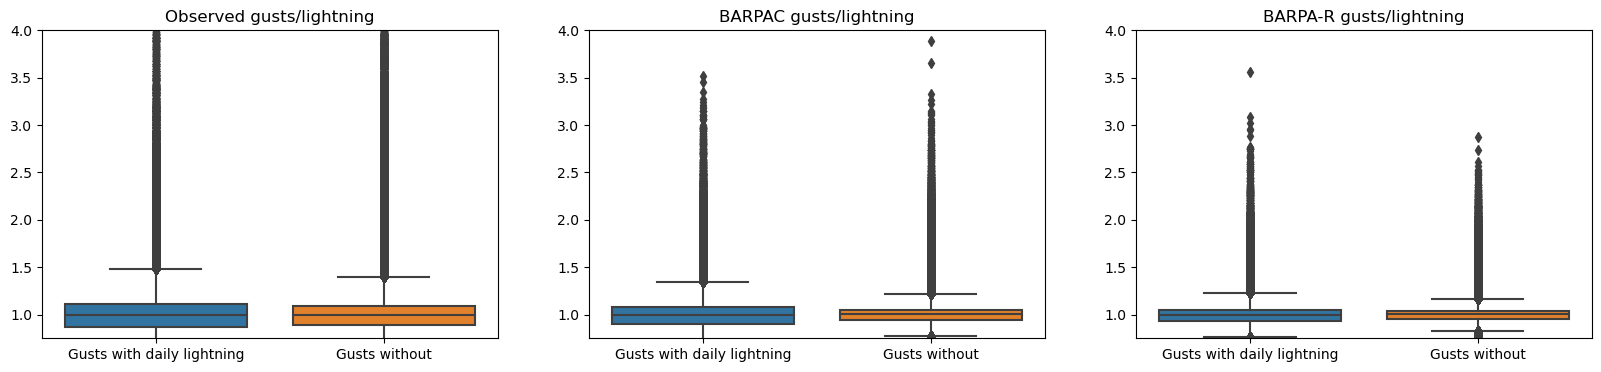

In [100]:
plt.figure(figsize=[20,4])

plt.subplot(1,3,1)

sns.boxplot(
    [df.query("(gust<100) & (Lightning_observed_daily>=1) ").wgr_4,
    df.query("(gust<100) & (Lightning_observed_daily==0) ").wgr_4])
plt.ylim([0.75,4])
plt.xticks([0,1],["Gusts with daily lightning","Gusts without"])
plt.title("Observed gusts/lightning")


plt.subplot(1,3,2)

sns.boxplot(
    [df.query("(n_lightning_fl>=1)").wgr_2p2km_point,
    df.query("(n_lightning_fl==0) ").wgr_2p2km_point])
plt.ylim([0.75,4])
plt.xticks([0,1],["Gusts with daily lightning","Gusts without"])
plt.title("BARPAC gusts/lightning")


plt.subplot(1,3,3)

sns.boxplot(
    [df.query("(n_lightning_fl>=1) ").wgr_12km_point,
    df.query("(n_lightning_fl==0) ").wgr_12km_point])
plt.ylim([0.75,4])
plt.xticks([0,1],["Gusts with daily lightning","Gusts without"])
plt.title("BARPA-R gusts/lightning")

<AxesSubplot:xlabel='Unnamed: 1'>

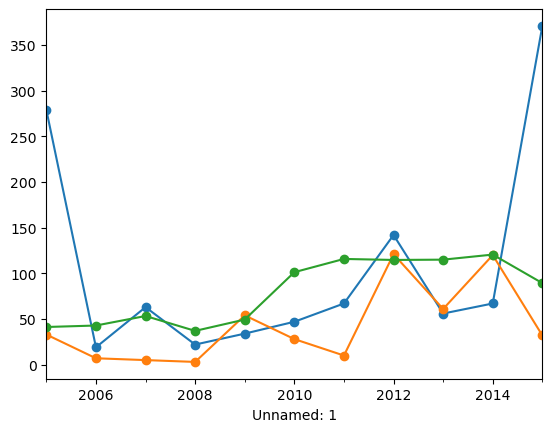

In [101]:
df.query("(n_lightning_fl>=1) & (wg10_2p2km_point>=25)").resample("1Y").count().max(axis=1).plot(marker="o")
df.query("(Lightning_observed_daily>=1) & (gust>=25)").resample("1Y").count().max(axis=1).plot(marker="o")
(df.query("(bdsd>=0.8)").resample("1Y").count().max(axis=1)/1000).plot(marker="o")